In [4]:
import pandas as pd
import numpy as np
import requests

In [5]:
def get_data(token):

    res = requests.get(
        f'https://api.cryptowat.ch/markets/coinbase-pro/{token}usd/ohlc',
        params={
            'periods': '3600',
            'after': str(int(pd.Timestamp('2021-11-22').timestamp()))
        }
    )
    if res.json().get('error',0)!=0:
        res = requests.get(
            f'https://api.cryptowat.ch/markets/kraken/{token}usd/ohlc',
            params={
                'periods': '3600',
                'after': str(int(pd.Timestamp('2021-11-22').timestamp()))
            }
        )

    df = pd.DataFrame(
        res.json()['result']['3600'],
        columns=['ts', 'open', 'high', 'low', 'close', 'volume', 'volumeUSD']
    )
    df['ts'] = pd.to_datetime(df.ts, unit='s')
    df['token'] = token
    
    return df

In [6]:
tokens = ['ETH', 'SOL', 'AVAX', 'USDT', 'FLOW']

In [7]:
df_lis = [get_data(token) for token in tokens]
df = pd.concat(df_lis,axis=0)

In [8]:
df['close_ratio']=df.loc[df['token'] == 'ETH', 'close']   /  df.loc[df['token'] == 'SOL', 'close']

In [9]:
df.groupby('token')['volumeUSD'].sum().to_frame().sort_values(by=['volumeUSD'])

,volumeUSD
token,
FLOW,9.243792e+07
USDT,2.128105e+09
AVAX,3.950965e+09
SOL,7.666180e+09
ETH,2.337456e+10


In [10]:
df.rename(columns={'volumeUSD': 'volumeTerm', 'volume': 'volumeBase'}, inplace=True)

In [12]:
close=df.pivot(index='ts', columns='token', values='close')
close

token,AVAX,ETH,FLOW,SOL,USDT
ts,,,,,
2021-11-22 00:00:00,128.67,4262.99,14.150,230.785,1.0012
2021-11-22 01:00:00,134.85,4234.37,13.621,226.000,1.0013
2021-11-22 02:00:00,132.54,4217.89,13.753,227.037,1.0012
2021-11-22 03:00:00,133.38,4193.47,13.652,223.117,1.0011
2021-11-22 04:00:00,136.29,4168.35,13.581,220.652,1.0009
...,...,...,...,...,...
2021-12-16 18:00:00,103.66,4035.15,8.785,182.640,1.0002
2021-12-16 19:00:00,103.67,4026.61,8.766,183.230,1.0003
2021-12-16 20:00:00,101.78,3997.95,8.707,180.040,1.0001


In [13]:
log_return = np.log(close/close.shift(1)).dropna(how='all',axis=0)
log_return

token,AVAX,ETH,FLOW,SOL,USDT
ts,,,,,
2021-11-22 01:00:00,0.046912,-0.006736,-0.038102,-0.020952,0.0001
2021-11-22 02:00:00,-0.017279,-0.003900,0.009644,0.004578,-0.0001
2021-11-22 03:00:00,0.006318,-0.005806,-0.007371,-0.017417,-0.0001
2021-11-22 04:00:00,0.021583,-0.006008,-0.005214,-0.011109,-0.0002
2021-11-22 05:00:00,-0.031832,-0.002472,-0.014014,-0.015161,-0.0001
...,...,...,...,...,...
2021-12-16 18:00:00,-0.018637,-0.011340,-0.003069,-0.010295,0.0000
2021-12-16 19:00:00,0.000096,-0.002119,-0.002165,0.003225,0.0001
2021-12-16 20:00:00,-0.018399,-0.007143,-0.006753,-0.017563,-0.0002


In [14]:
correlation=log_return.corr()
correlation

token,AVAX,ETH,FLOW,SOL,USDT
token,,,,,
AVAX,1.000000,0.649717,0.396980,0.635399,-0.004474
ETH,0.649717,1.000000,0.574316,0.749026,-0.106582
FLOW,0.396980,0.574316,1.000000,0.464544,-0.186943
SOL,0.635399,0.749026,0.464544,1.000000,0.103241
USDT,-0.004474,-0.106582,-0.186943,0.103241,1.000000


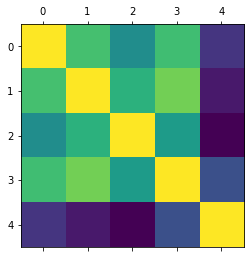

In [15]:
import matplotlib.pyplot as plt

plt.matshow(correlation)
plt.show()